In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison
import seaborn as sns
import warnings
from pylab import rcParams


%matplotlib inline
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 20,10
rcParams['font.size'] = 30
sns.set()
np.random.seed(8)

In [3]:
# import data
data = pd.read_csv('data/Final_Data.csv') # from local path

In [4]:
# collect data on specific locations
atlanta_df = data.loc[data['location'] == 'Atlanta, GA', ['score', 'score2']][:2400]
nyc_df = data.loc[data['location'] == 'New York, NY', ['score', 'score2']][:2400]
losangeles_df = data.loc[data['location'] == 'Los Angeles, CA', ['score', 'score2']][:2400]
indianapolis_df = data.loc[data['location'] == 'Indianapolis, IN', ['score', 'score2']][:2400]
seattle_df = data.loc[data['location'] == 'Seattle, WA', ['score', 'score2']][:2400]
houston_df = data.loc[data['location'] == 'Houston, TX', ['score', 'score2']][:2400]
denver_df = data.loc[data['location'] == 'Denver, CO', ['score', 'score2']][:2400]
minneapolis_df = data.loc[data['location'] == 'Minneapolis, MN', ['score', 'score2']][:2400]

atlanta_df['location'] = "ATL"
nyc_df['location'] = "NYC"
losangeles_df['location'] = "LA"
indianapolis_df['location'] = "IND"
seattle_df['location'] = "SEA"
houston_df['location'] = "HOU"
denver_df['location'] = "DEN"
minneapolis_df['location'] = "MIN"

dframes = [atlanta_df, nyc_df, losangeles_df, indianapolis_df, seattle_df, houston_df, denver_df, minneapolis_df]
final_data = pd.concat(dframes, ignore_index=True)
final_data.rename(columns = {'score':'sigmoid', 'score2':'tanh'}, inplace = True)
final_data = final_data.reindex(columns=['location','sigmoid','tanh'])

In [5]:
# split data by job location
atlanta_df = final_data.loc[final_data['location'] == 'ATL']
nyc_df = final_data.loc[final_data['location'] == 'NYC']
losangeles_df = final_data.loc[final_data['location'] == 'LA']
indianapolis_df = final_data.loc[final_data['location'] == 'IND']
seattle_df = final_data.loc[final_data['location'] == 'SEA']
houston_df = final_data.loc[final_data['location'] == 'HOU']
denver_df = final_data.loc[final_data['location'] == 'DEN']
minneapolis_df = final_data.loc[final_data['location'] == 'MIN']

<h2>EDA</h2>

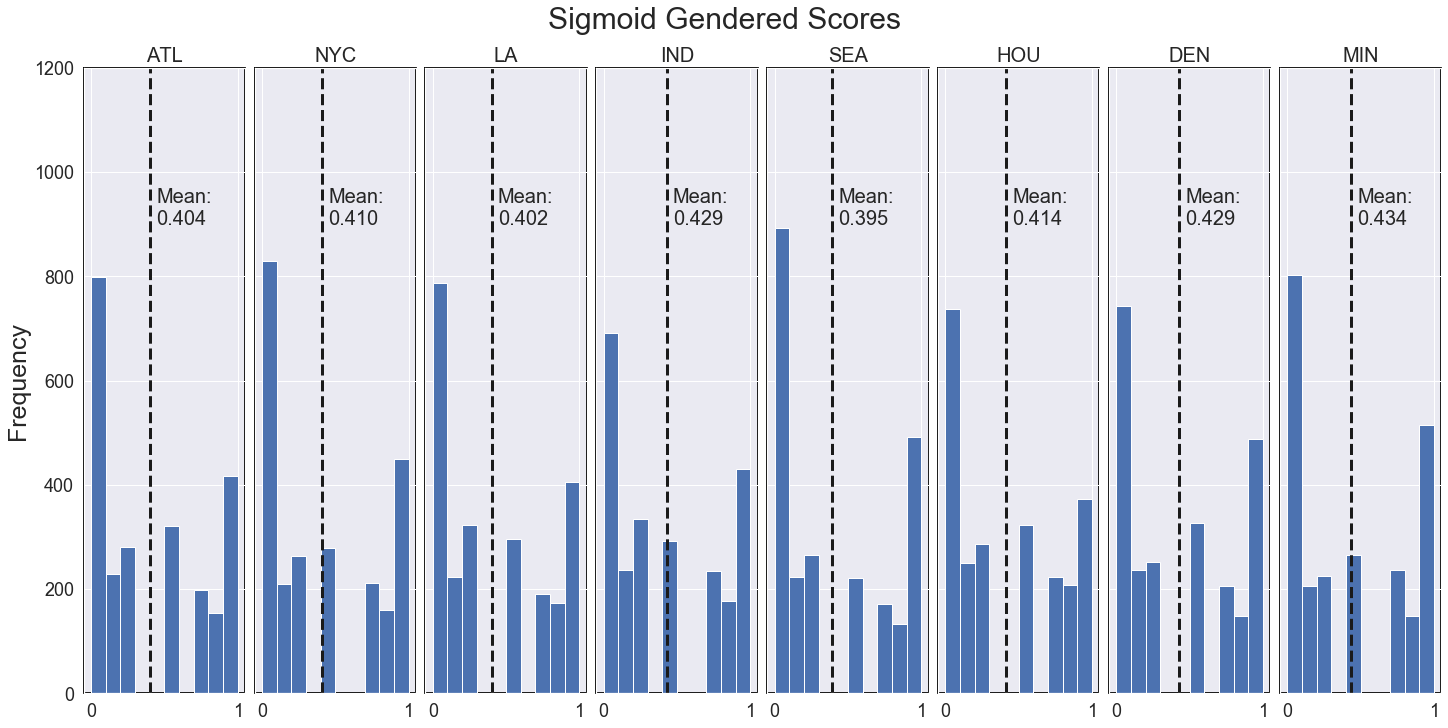

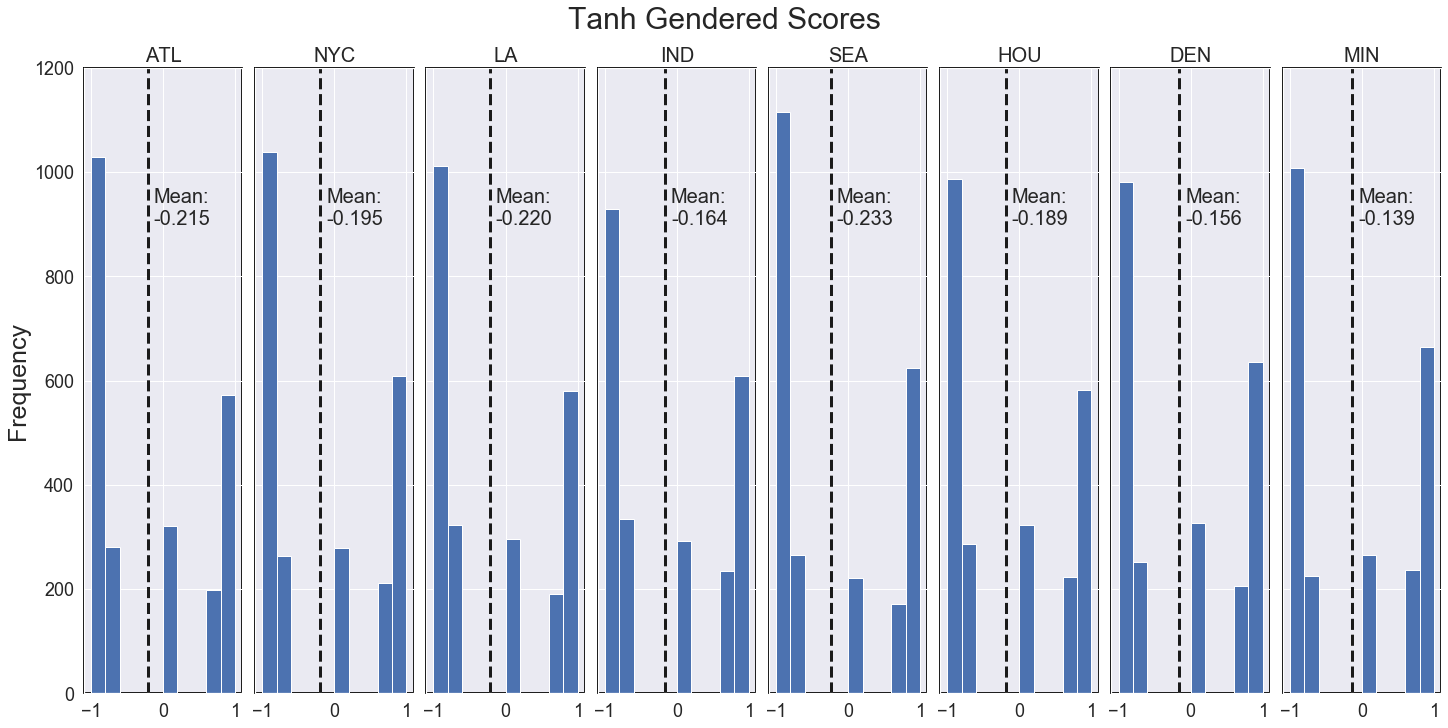

In [12]:
locations = ['ATL', 'NYC', 'LA', 'IND', 'SEA', 'HOU', 'DEN', 'MIN']

city_data_sigmoid = [atlanta_df['sigmoid'], nyc_df['sigmoid'], losangeles_df['sigmoid'], 
             indianapolis_df['sigmoid'], seattle_df['sigmoid'], houston_df['sigmoid'], 
             denver_df['sigmoid'], minneapolis_df['sigmoid']]

city_data_tanh = [atlanta_df['tanh'], nyc_df['tanh'], losangeles_df['tanh'],
             indianapolis_df['tanh'], seattle_df['tanh'], houston_df['tanh'],
             denver_df['tanh'], minneapolis_df['tanh']]

def make_plots(locations, city_data, setting, plot_title):
    n_bins = 10
    fig, axs = plt.subplots(1, len(locations), sharey=True, constrained_layout=True)
    fig.suptitle(plot_title, size=30)
    axs[0].set_ylabel("Frequency", size=25)
    # axs[2].set_xlabel("Score", size=20)

    for i in range(len(locations)):
        axs[i].hist(city_data[i], bins=n_bins)
        axs[i].patch.set_edgecolor('black')
        axs[i].patch.set_linewidth('2')
        axs[i].set_title(locations[i], size=20)
        axs[i].set_ylim(0,1200)
        axs[i].tick_params(axis='both', which='major', labelsize=18)
        axs[i].axvline(np.mean(city_data[i].values), color="k", linestyle="dashed", linewidth=3)
        if setting == "sigmoid":
            axs[i].text(
                city_data[i].mean() + city_data[i].mean() / 10,
                900,
                "Mean:\n{:.3f}".format(np.mean(city_data[i].values)), fontsize=20
            )
        else:
            axs[i].text(
                (city_data[i].mean() + city_data[i].mean() / 10) + .1,
                900,
                "Mean:\n{:.3f}".format(np.mean(city_data[i].values)), fontsize=20
            )

    # plt.savefig(plot_title + '.png')


make_plots(locations, city_data_sigmoid, "sigmoid", "Sigmoid Gendered Scores")
make_plots(locations, city_data_tanh, "tanh", "Tanh Gendered Scores")

<b>Observations:</b> Seattle has the most job postings that specifically target male applicants, while Indianapolis has the least. Minneaapolis has the most job postings that specifically target female applicants, while Atlanta has the least. Seattle has the least job postings that are gender neutral. <br>
<br>
Note: Within Minneapolis, there are much more male targeted job postings than female targeted postings. However, Minneapolis has the highest female percentage in the labor force (72.6%) compared to the other locations.

<h2>ANOVA Testing</h2>

<h3>Preparing Data for statsmodels package</h3>

In [7]:
ATL_sigmoid = atlanta_df['sigmoid'].tolist()
NYC_sigmoid = nyc_df['sigmoid'].tolist()
LA_sigmoid = losangeles_df['sigmoid'].tolist()
IND_sigmoid = indianapolis_df['sigmoid'].tolist()
SEA_sigmoid = seattle_df['sigmoid'].tolist()
HOU_sigmoid = houston_df['sigmoid'].tolist()
DEN_sigmoid = denver_df['sigmoid'].tolist()
MIN_sigmoid = minneapolis_df['sigmoid'].tolist()

ATL_tanh = atlanta_df['tanh'].tolist()
NYC_tanh = nyc_df['tanh'].tolist()
LA_tanh = losangeles_df['tanh'].tolist()
IND_tanh = indianapolis_df['tanh'].tolist()
SEA_tanh = seattle_df['tanh'].tolist()
HOU_tanh = houston_df['tanh'].tolist()
DEN_tanh = denver_df['tanh'].tolist()
MIN_tanh = minneapolis_df['tanh'].tolist()


length = 2400
sigmoid_scores = ATL_sigmoid + NYC_sigmoid + LA_sigmoid + IND_sigmoid + SEA_sigmoid + HOU_sigmoid + DEN_sigmoid + MIN_sigmoid
tanh_scores = ATL_tanh + NYC_tanh + LA_tanh + IND_tanh + SEA_tanh + HOU_tanh + DEN_tanh + MIN_tanh
city_names = (['ATL'] * length) +  (['NYC'] * length) +  (['LA'] * length) +  (['IND'] * length) +  (['SEA'] * length) +  (['HOU'] * length) + (['DEN'] * length) + (['MIN'] * length)

sigmoid_data = pd.DataFrame({'location': city_names, 'score': sigmoid_scores})
tanh_data = pd.DataFrame({'location': city_names, 'score': tanh_scores})

<h3>Mean Scores</h3>

In [8]:
print("Sigmoid Mean Scores\n", sigmoid_data.groupby('location').mean())
print("\nTanh Mean Scores\n", tanh_data.groupby('location').mean())

Sigmoid Mean Scores
              score
location          
ATL       0.403591
DEN       0.429376
HOU       0.413716
IND       0.428838
LA        0.402435
MIN       0.433974
NYC       0.409991
SEA       0.394856

Tanh Mean Scores
              score
location          
ATL      -0.214981
DEN      -0.156212
HOU      -0.188652
IND      -0.164387
LA       -0.220219
MIN      -0.138544
NYC      -0.195151
SEA      -0.233321


<h3>1-Way ANOVA Using StatsModels</h3>
<i><b>Null hypotheses:</b> There is no significant variation in the means of gendered scores of the locations.<br></i>
<i><b>Alternative hypotheses:</b> At least one location's mean is different from other locations (there is significant variation).</i><br>
The alpha the ANOVA will be tested at is 0.05.

In [9]:
def anova(data, test_title):
    print("==============================================================================")
    print(test_title)
    print("==============================================================================")
    lm = ols('score ~ location', data=data).fit()
    table = sm.stats.anova_lm(lm)
    print(table, "\n\n")
    print(lm.summary())

anova(sigmoid_data, "One-Way ANOVA F-test using sigmoid scores")
print("\n\n")
anova(tanh_data, "One-Way ANOVA F-test using tanh scores")

One-Way ANOVA F-test using sigmoid scores
               df       sum_sq   mean_sq         F    PR(>F)
location      7.0     3.545833  0.506548  3.441956  0.001102
Residual  19192.0  2824.458246  0.147169       NaN       NaN 


                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.442
Date:                Tue, 02 Jun 2020   Prob (F-statistic):            0.00110
Time:                        18:15:23   Log-Likelihood:                -8844.3
No. Observations:               19200   AIC:                         1.770e+04
Df Residuals:                   19192   BIC:                         1.777e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                        

<b>Observations:</b><br>
<b>Using Sigmoid Scores:</b><br>
F(7,19192) = 3.441956 p = 0.001102<br>
The P-value obtained from ANOVA analysis is significant (P<0.05), and therefore, we conclude that there are significant differences among the locations.

<b>Using Tanh Scores:</b><br>
F(7,19192) = 3.629531 p = 0.000646<br>
The P-value obtained from ANOVA analysis is significant (P<0.05), and therefore, we conclude that there are significant differences among the locations.

<h3>Post hoc Testing</h3><br>
From ANOVA analysis, we know that the differences of gendered wording scores of the job locations are statistically significant, but ANOVA does not tell which locations are significantly different from each other. To know the pairs of significant different locations, we will perform multiple pairwise comparison (Post-hoc comparison) analysis using Tukey HSD test.

In [10]:
def tukey (data, test_title):
    print("----------------------------------------------------")
    print(test_title)
    print("====================================================")
    mc = MultiComparison(data['score'], data['location'])
    mc_results = mc.tukeyhsd()
    print(mc_results)


tukey(sigmoid_data, "Tukey's HSD Post-Hoc Comparison using sigmoid scores")
print("\n")
tukey(tanh_data, "Tukey's HSD Post-Hoc Comparison using tanh scores")

----------------------------------------------------
Tukey's HSD Post-Hoc Comparison using sigmoid scores
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   ATL    DEN   0.0258 0.2781 -0.0078  0.0594  False
   ATL    HOU   0.0101    0.9 -0.0234  0.0437  False
   ATL    IND   0.0252 0.3048 -0.0083  0.0588  False
   ATL     LA  -0.0012    0.9 -0.0347  0.0324  False
   ATL    MIN   0.0304   0.11 -0.0032   0.064  False
   ATL    NYC   0.0064    0.9 -0.0272    0.04  False
   ATL    SEA  -0.0087    0.9 -0.0423  0.0248  False
   DEN    HOU  -0.0157  0.834 -0.0492  0.0179  False
   DEN    IND  -0.0005    0.9 -0.0341   0.033  False
   DEN     LA  -0.0269 0.2255 -0.0605  0.0066  False
   DEN    MIN   0.0046    0.9  -0.029  0.0382  False
   DEN    NYC  -0.0194 0.6329  -0.053  0.0142  False
   DEN    SEA  -0.0345 0.0387 -0.0681  -0.001   True
   HOU    IND   0.0151  0.863 -0.0184  0.0487 

<b>Observations:</b><br>
<b>Using Sigmoid Scores:</b><br>
Results show that all pairwise comparisons of job locations, except DEN-SEA, IND-SEA, and MIN-SEA, rejects the null hypothesis and indicates statistically significant differences. Seattle shows the most statistical  difference in scores than any other location.

<b>Using Tanh Scores:</b><br>
Results show that all pairwise comparisons of job locations, except ATL-MIN, DEN-SEA, LA-MIN, and MIN-SEA, rejects the null hypothesis and indicates statistically significant differences. Minneapolis shows the most statistical difference in scores than any other location.

<h3>Overall Observations and Discussion:</h3><br>
<ol>
    <li><b>Minneapolis</b> has the highest female percentage in the labor force, while <b>NYC</b> has the lowest.</li>
    <li><b>Minneapolis</b> has the highest gendered wording mean score (sigmoid=0.433974, tanh=-0.138544), while <b>Seattle</b> has the lowest (sigmoid=0.394856, tanh=-0.233321).</li>
    <li>In ANOVA testing, we concluded that there <b>are</b> significant differences among the gendered wording scores of the job locations.</li>
    <li>In the Tukey range test using the sigmoid scores, we found that <b>Seattle</b> showed the most statistical difference in scores than any other location.</li>
    <li>In the Tukey range test using the tanh scores, we found that <b>Minneapolis</b> showed the most statistical difference in scores than any other location.</li>
    <li>From observing the score distributions plots, the data use was not normally distibuted. By randomly selecting the job descriptions, the data could have been unintentionally overwhelmed with male targeted job descriptions (OR there was just a greater number of male targeted job postings in general?).</li>
    <li>The two different gendered score measures output different results in the range Tukey tests, which could be due to how the tanh scores are more skewed than the sigmoid scores.</li>
</ol>